# EEG seizure prediction

[Article](http://yann.lecun.com/exdb/publis/pdf/mirowski-cneuro-09.pdf)

In [40]:
import mne
import matplotlib.pyplot as plt
import re
import pandas as pd
import numpy as np
import json
import os
import scipy.signal as signal
from sklearn.neighbors import NearestNeighbors
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
from sklearn.model_selection import cross_val_predict

**Remark**

I have only put the *chb02* patient data in the data folder, it contains some extracted features during the project, and the JSON annotations extracted during the project. 
However the raw eeg's are still quite heavy. 

In [2]:
###################################################
# Config
###################################################


SAMPLE_RATE = 256 #sample rate of EEG recordings 
N = 1280 # length for features comput  in nb of samples
PREICTAL_DURATION = 2*3600*SAMPLE_RATE # Duration of preictal phase in number of samples
POSTICTAL_DURATION = int(.5*3600*SAMPLE_RATE) # Duration of postictal phase in number of samples


# Change data path (only the tested patient was put in data due to the important size of the samples)
# DATA_PATH = "data"
DATA_PATH = "/mnt/PEZ/chb_data/"

# NB_SUB_DELAYS = 16 # number of delays tested for the maximal autocorrelation
# delays = np.concatenate((-np.arange(0, SAMPLE_RATE//2+1, SAMPLE_RATE//(NB_SUB_DELAYS))[::-1][:-1], np.arange(0, SAMPLE_RATE//2+1, SAMPLE_RATE//(NB_SUB_DELAYS))))
# delays = np.concatenate((-np.arange(0, SAMPLE_RATE//2+1, SAMPLE_RATE//(NB_SUB_DELAYS))[::-1][:-1], np.arange(0, SAMPLE_RATE//2+1, SAMPLE_RATE//(NB_SUB_DELAYS))))
DELAYS = np.arange(-SAMPLE_RATE//2, SAMPLE_RATE//2 +1)

# Utils

In [33]:
def load_egg_path(path):
    """ Return loaded mne data from .edf file from path"""
    return mne.io.read_raw_edf(path)

def load_egg_path_2(patient_name, file_name):
    """ Return loaded mne data from .edf file from patient name, and file name"""
    return mne.io.read_raw_edf(os.path.join(DATA_PATH, patient_name, file_name))

In [4]:
def plot_stacked(data, start, end, figsize=(30, 15)):
	""" Plot stacked signals, from `start' to `end`. Return matplotlib figure and axis"""
	fig, axs = plt.subplots(len(data), figsize=figsize)
	for i,ax in enumerate(axs):
		ax.plot(data[i, start:end])
	return fig, axs

In [34]:
def make_seizure_file(source_path, patient, summary_name):
	""" Build per-file JSON seisures annotation for the CHB-MIT dataset from summary txt file provided in the dataset
		Annotation are of the form [[start1, end1], [start2, end2], ... ]
		JSON files are saved with the same same, in the same folder as the recordings

	Parameters
	----------
	source_path : str
		data path
	patient : str
		patient name
	summary_name : str
		summary text file name
	"""
	with open(os.path.join(source_path,"{}/{}".format(patient, summary_name))) as f:
		content = f.readlines()
		i = 0
		while i < len(content): 
			line = content[i]
			if line[:9] == "File Name":
				seizures = []
				file_name = line.strip()[11:-4]
				nb_seizures = int(content[i+3].strip()[28:])
				for j in range(nb_seizures):
					start_time =int(re.sub('\D', '', content[i+3+2*j+1].strip()))
					end_time =int(re.sub('\D', '', content[i+3+2*j+2].strip()))
					seizures.append([start_time, end_time])
				# if nb_seizures:
				json.dump(seizures, open( os.path.join(source_path,patient,file_name + ".json"), "w+"))
			i+=1

In [6]:
def load_signal(patient, file):
	""" Return numpy signal and seizure annotation list given patient name, and file name (without .edf)"""
	
	path_eeg = os.path.join(DATA_PATH, patient, file + ".edf")
	path_seizures = os.path.join(DATA_PATH, patient, file + ".json")

	data = mne.io.read_raw_edf(path_eeg, verbose = 0).get_data(verbose = 0)
	seizures = json.load(open(path_seizures))
	return data, seizures

In [7]:
def save_features_labels(X, Y, data_path, patient, suffix):
	""" Saves features and labels in numpy format: patient_X[suffix].npy and patient_Y[suffix].npy"""

	np.save(os.path.join(data_path, patient, patient + "_X" + suffix), X)
	np.save(os.path.join(data_path, patient, patient + "_Y" + suffix), Y)
	return
	
def load_features_labels(data_path, patient,suffix = ""):
	""" Loads features and labels in numpy format: patient_X[suffix].npy and patient_Y[suffix].npy"""
	
	X = np.load(os.path.join(data_path, patient, patient + "_X"+ suffix + ".npy"))
	Y = np.load(os.path.join(data_path, patient, patient + "_Y" + suffix + ".npy"))
	return X,Y

def plot_conf_matrix(Y_true, Y_pred, figsize = (3,3)):
	"""Plots confidence matrix with given figsize """
	
	fig, ax = plt.subplots(figsize= figsize)
	disp = ConfusionMatrixDisplay(confusion_matrix(Y_true, Y_pred))
	disp.plot(ax = ax)
	return fig, ax


# Data

In [ ]:
# Extract seizures times and save JSON from original dataset text file
make_seizure_file(DATA_PATH, "chb02", "chb02-summary.txt")

In [101]:
# Load data from patient
data, seizures = load_signal("chb02", "chb02_19")
print("Signal duration:{}s, {} seizure period".format(data.shape[1]/SAMPLE_RATE, len(seizures)))

/tmp/ipykernel_15879/1338812077.py:8: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(path_eeg, verbose = 0).get_data(verbose = 0)


Signal duration:3600.0s, 1 seizure period


In [36]:
data, seizures = load_signal("chb02", "chb02_19")

# Extract a minute of preictal part and interictal part
preictal_part = data[:,(seizures[0][0])*SAMPLE_RATE - N*12: (seizures[0][0])*SAMPLE_RATE]
preictal_part = preictal_part - preictal_part.mean(axis = 1)[:, np.newaxis]

interictal_part = data[:,60*SAMPLE_RATE: 60*SAMPLE_RATE + N*12]
interictal_part = interictal_part - interictal_part.mean(axis = 1)[:, np.newaxis]

/tmp/ipykernel_2614/3928774315.py:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(path_eeg, verbose = 0).get_data(verbose = 0)


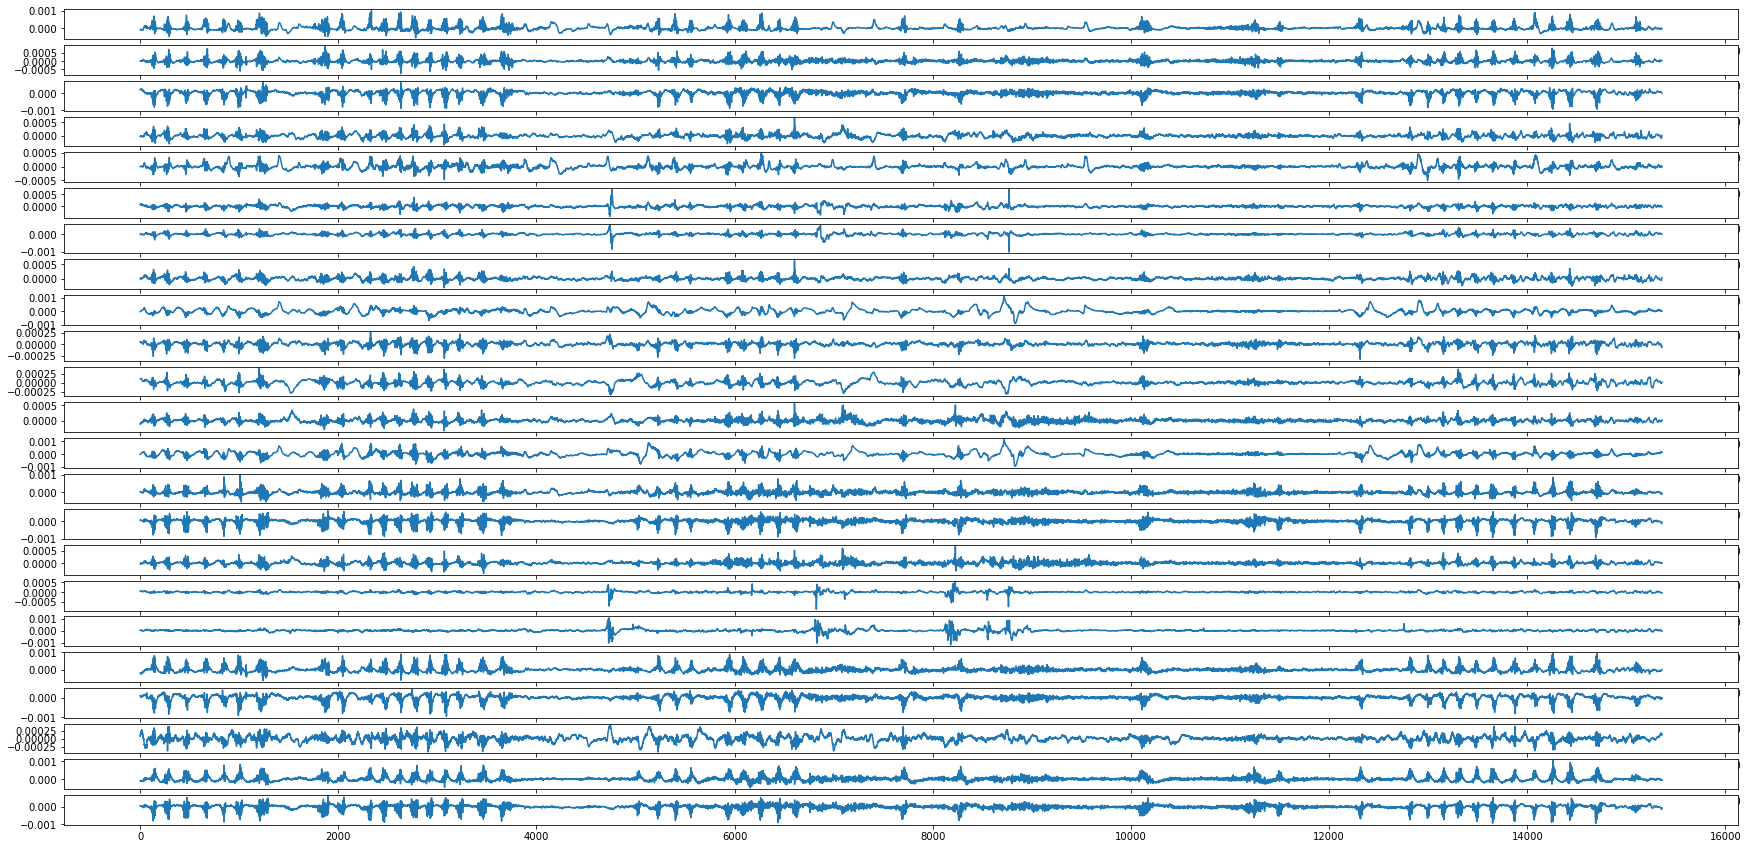

In [238]:
# Plot the preictal signal
plot_stacked(preictal_part, 0, preictal_part.shape[1])
# plot_stacked(preictal_part[:3,:], 0, preictal_part.shape[1], figsize=(20,3))
# plt.savefig(fname=f"preictal.pdf", dpi=200, transparent=True, bbox_inches="tight", pad_inches=0)

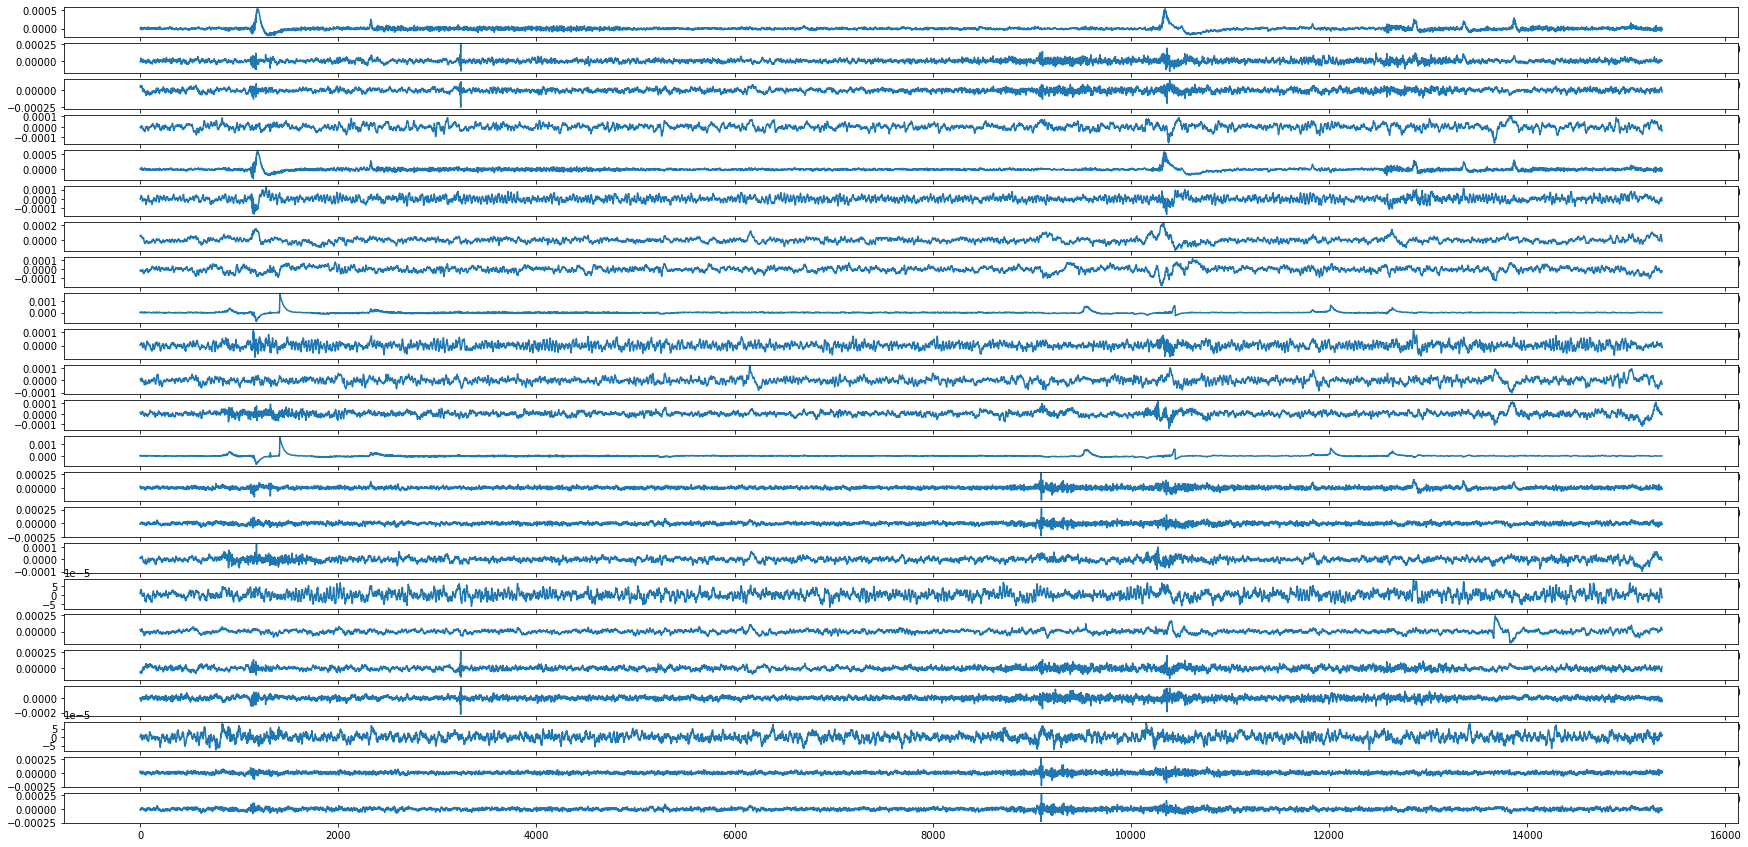

In [38]:
# Plot the interictal signal
plot_stacked(interictal_part, 0, interictal_part.shape[1])
None

Let's try to low-paass the filter using a butterworth filter and plot the original, filtered, and difference signals

In [53]:
# Observe the
b, a = signal.butter(5, .5, 'low')
filtered =signal.filtfilt(b, a, preictal_part)

Text(0.5, 0.98, 'Original, filtered, difference')

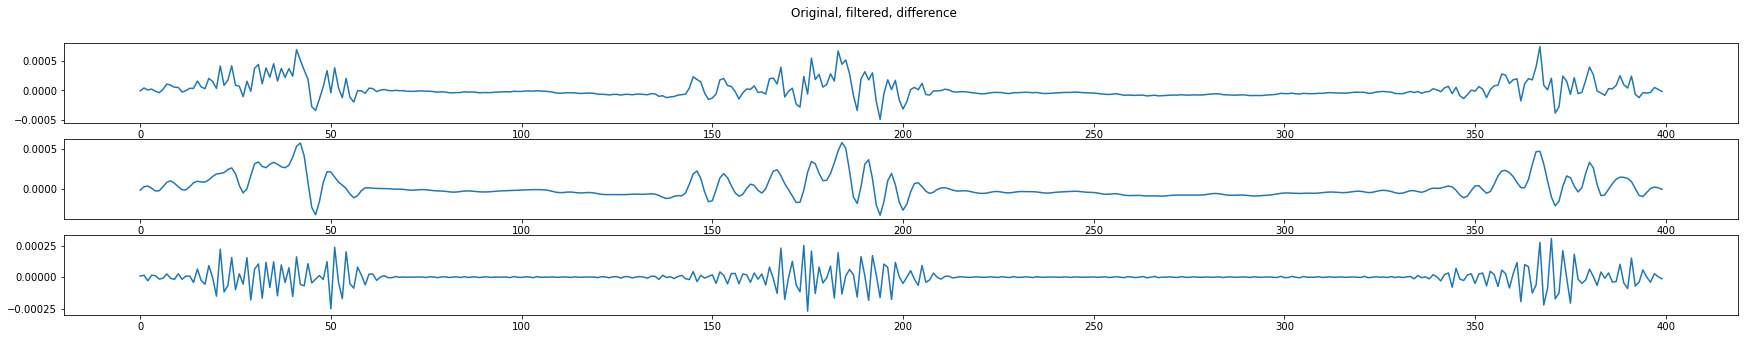

In [58]:
fig, ax = plot_stacked(np.array([preictal_part[0], filtered[0], preictal_part[0] - filtered[0]]), 100, 500, figsize=(30, 5))
fig.suptitle("Original, filtered, difference")

# Features

## A.Maximal cross correlation

In [81]:
def C_delay(x1,x2, tau):
	""" Cross correlation with shift, tau is the shift in samples"""
	if tau == 0:
		return (x1@x2)/len(x1)
	elif tau > 0:
		return (x1[tau:]@x2[:-tau])/(len(x1) - tau)
	else:
		return C_delay(x2,x1, -tau)
def CrossCorrelation(x1, x2, delays):
	""" Max cross correlation with given delays array"""
	denom = np.sqrt(np.sum(x1**2)*np.sum(x2**2))
	return np.max([abs(C_delay(x1,x2, tau)) for tau in delays])/denom

def makeCcFeatures(windowed_data):
	return np.array([CrossCorrelation(windowed_data[i], windowed_data[j], DELAYS)  for i in range(len(windowed_data)) for j in range(i+1, len(windowed_data))])

In [315]:
data, seizures = load_signal("chb02", "chb02_01")

/tmp/ipykernel_15879/1338812077.py:8: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(path_eeg, verbose = 0).get_data(verbose = 0)


In [336]:
windowed = data[:, :N]
# CrossCorrelation(windowed[0], windowed[1], DELAYS)
for i in range (10):
	makeCcFeatures(windowed)

## B. Nonlinear interdependance

In [84]:
def timeDelayEmbedding (data, delay, dimension):
    "Time delay embedding of data with delay into dimension, delay*dimension must be < len(data)"
    return np.array([data[i*delay:len(data) - delay*(dimension - i)] for i in range(dimension)]).T

In [74]:
def get_Knn_indices(x_embedding, K):
	""" Get K nearest neighbours indices of `x_embedding` exclusing itself"""
	nbrs = NearestNeighbors(n_neighbors=K+1, algorithm='ball_tree').fit(x_embedding)
	_, indices = nbrs.kneighbors(x_embedding)
	return indices[:,1:]

In [75]:
def compute_R(x_embed, knn_indices):
	return np.mean(np.sum((x_embed[knn_indices] - x_embed[:,np.newaxis,: ])**2, axis = 2), axis = 1)

def compute_R_bis(x1_embed, knn_indices_2):
	return compute_R(x1_embed, knn_indices_2)

In [76]:
TD_DELAY = 6
TD_DIM = 20
K = 5

def make_nonlinear_indep_features(X):
	""" Compute the nonlinear independance features of X"""
	
	embed_X = np.array([timeDelayEmbedding(x, TD_DELAY, TD_DIM) for x in X ])
	knn_indices = np.array([get_Knn_indices(embed_x, K) for embed_x in embed_X])
	R = np.array([compute_R(x_embed, knn_indices[i]) for i,x_embed in enumerate(embed_X)])

	R_bis = np.array([[compute_R_bis(embed_X[i], knn_indices[j]) for j in range(len(X))] for i in range(len(X))])
	S = np.mean(R/R_bis, axis = 2)
	S = (S + S.T)/2
	S = np.concatenate([S[i,i+1:]for i in range(len(S)-1)])
	return S

# Classif

## Compute features

In [79]:
def cut_features_cut(list_data, N_subframe, nb_frames, feature_type = None):
	""" For each multivariate data in `list_data`, compute bivariate features on cut windows of `N_subframes` samples, and stacks `nb_frames` window features

	Parameters
	----------
	list_data : list[ndarray]
		list of signals to cut and extract features from
	N_subframe : int
		Size of window to compute features
	nb_frames : int
		Number of stacked feature vectors 
	feature_type : str, optional
		Type of signal given in input, for verbose, by default None

	Returns
	-------
	ndarray
		3 dimensional array of stacked features (number of elements, nb_frames, number of bivariates features)
		
	"""
	list_features = []

	for data in list_data:
		if feature_type is not None: print("Computing", feature_type,  "features  period of", data.shape[1]/SAMPLE_RATE, "s")
	
		cut = data[:, data.shape[1]%N_subframe:]
		windows = [cut[:, N_subframe*i: N_subframe*i + N_subframe] for i in range(cut.shape[1]//N_subframe)]

		sub_features = np.array([makeCcFeatures(w) for w in windows])
		# sub_features = np.array([make_nonlinear_indep_features(w) for w in windows])
		
		sub_features = sub_features[len(sub_features)%nb_frames:]

		features = np.array([sub_features[i*nb_frames: i*nb_frames +nb_frames] for i in range(len(sub_features)//nb_frames)])
		list_features.append(features)

	if len(list_features):
		return np.concatenate(list_features, axis = 0)
	else:
		return None


def compute_features(patient, file,N_subframe, nb_frames, filter = False):
	""" 
	Load eeg and seizure times
	Discard ictal and postictal episodes
	Return  features and vectors of preictal(1) and interictal(0) periods
	"""

	print("****************************************")
	data, seizures = load_signal(patient, file) # Load data

	# Filter the signal (low pass)
	if filter:
		b, a = signal.butter(5, .5, 'low')
		data = signal.filtfilt(b, a, data)


	print("Computing feratures for patient {patient}, file {file}, window of {nb_frames} frames".format(patient=patient, file=file, nb_frames=nb_frames))
	print("Data:", data.shape[0], "channels,", data.shape[1]/SAMPLE_RATE, "s")


	preictal_periods = []
	interictal_periods = []

	start_interictal = 0

	# Run though seizures and select interictal and preictal periods and store them
	for seiz in seizures:
		start_seiz = SAMPLE_RATE*seiz[0]
		end_seiz = SAMPLE_RATE*seiz[1]

		start_preictal = max(0, start_seiz - PREICTAL_DURATION)
		if start_preictal > 0:
			interictal_periods.append(data[:, start_interictal:start_preictal])
		preictal_periods.append(data[:, start_preictal: start_seiz])

		start_interictal = end_seiz + POSTICTAL_DURATION
	
	if start_interictal < data.shape[1]:
		interictal_periods.append(data[:, start_interictal:])

	# Check
	for x in preictal_periods:
		if x.shape[1] ==0: raise ValueError("Empty preictal period computed !")
	for x in interictal_periods:
		if x.shape[1] ==0: raise ValueError("Empty interict period computed !")

	# Compute features over well sized windows, and aggregate over nb_frames windows
	preictal_features = cut_features_cut(preictal_periods, N_subframe, nb_frames, feature_type = "preictal")
	interictal_features = cut_features_cut(interictal_periods, N_subframe, nb_frames, feature_type = "interictal")

	print("****************************************")
	print()
	return preictal_features, interictal_features

Let's observe one random feature of each class to try to see differences

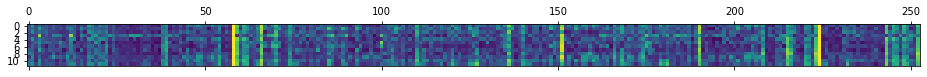

In [92]:
plt.matshow(cut_features_cut([preictal_part], N, 12)[0])
plt.savefig(fname=f'vector_stack.pdf', dpi=200, transparent=True, bbox_inches='tight', pad_inches=0)

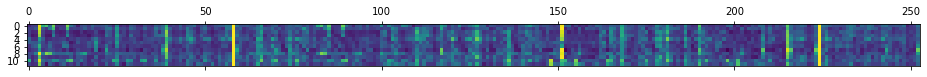

In [83]:
plt.matshow(cut_features_cut([interictal_part], N, 12)[0])

In [10]:
# files_chb02 = os.listdir(os.path.join(DATA_PATH, "chb02"))
# files_chb02 = [f.split(".edf")[0] for f in files_chb02 if f[-4:] == ".edf" ]
# sub_files_chb02 = [ 'chb02_14','chb02_15','chb02_16+','chb02_16','chb02_17','chb02_18']

In [168]:
def get_file_names(patient):
	""" Lsit file names in a patient folder"""
	files = os.listdir(os.path.join(DATA_PATH, patient))
	files = [f.split(".edf")[0] for f in files if f[-4:] == ".edf" ]
	return files

In [ ]:
patient = "chb02"
files = get_file_names(patient)
# features = [compute_features(patient, file, N_subframe=N, nb_frames=12) for file in files]
features = [compute_features(patient, file, N_subframe=N, nb_frames=12, filter = True) for file in files]

In [373]:
preictal_features, interictal_features = zip(*features)

In [381]:
preictal_features = [x for x in preictal_features if x is not None]
interictal_features = [x for x in interictal_features if x is not None]

In [199]:
# interictal_features.pop(32)

array([], dtype=float64)

In [382]:
pi_X = np.concatenate(preictal_features, axis = 0)
pi_Y = np.ones(len(pi_X))


In [383]:
ii_X = np.concatenate(interictal_features, axis = 0)
ii_Y = np.zeros(len(ii_X))

In [384]:
X = np.concatenate([ii_X, pi_X])
Y = np.concatenate([ii_Y, pi_Y])

In [385]:
assert len(X) == len(Y)
assert X.shape[1:] == (12,253)

In [386]:
# suffix = "filtered"
# suffix = "_filter_alldelay"
suffix = "_nonlinindep"
np.save(os.path.join(DATA_PATH, patient, patient + "_X" + suffix), X)
np.save(os.path.join(DATA_PATH, patient, patient + "_Y" + suffix), Y)

## Classif

### Load saved features

In [85]:
patient = "chb02"

suffix = ""
# suffix = "_filtered"
# suffix = "_filter_alldelay"
# suffix = "_nonlinindep"

X, Y  = load_features_labels(DATA_PATH, patient, suffix)

In [480]:
X[np.isnan(X)] = 100

In [86]:
X = (X-X.mean(axis = 0))/ X.std(axis = 0)

In [87]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .3, shuffle=True)

In [298]:
X.shape

(2087, 12, 253)

### SVM

In [ ]:
parameters = {'kernel':['rbf'], 'C':[1, 10,100,1000], 'gamma': [.001,.01,.1,1]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, verbose = 2, scoring = 'recall')
clf.fit(X.reshape((X.shape[0],-1)), Y)

In [110]:
clf.best_params_

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

In [111]:
clf.best_score_

0.5632034632034633

In [475]:
from sklearn.model_selection import cross_validate

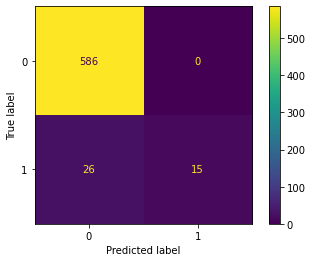

In [497]:
clf_2 = SVC(C = 100, gamma = .001, kernel = 'rbf').fit(X_train.reshape((X_train.shape[0],-1)), Y_train)
Y_predict = clf_2.predict(X_test.reshape((X_test.shape[0],-1)))

disp = ConfusionMatrixDisplay(confusion_matrix(Y_test, Y_predict))
disp.plot()

In [88]:
clf = SVC(C = 100, gamma = .001, kernel = 'rbf')
Y_pred = cross_val_predict(clf, X.reshape((len(X),-1)), Y, cv=5)

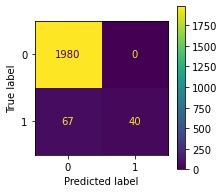

In [89]:
fig, _ = plot_conf_matrix(Y, Y_pred)
fig.savefig(fname='figures/svm_cv{}.pdf'.format(suffix), dpi=200, transparent=True, bbox_inches='tight', pad_inches=0)

### Random forest

In [90]:
clf = RandomForestClassifier(n_estimators=100)
Y_pred = cross_val_predict(clf, X.reshape((len(X),-1)), Y, cv=5)

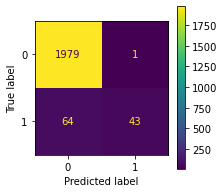

In [91]:
fig, _ = plot_conf_matrix(Y, Y_pred)
fig.savefig(fname='figures/svm_rf{}.pdf'.format(suffix), dpi=200, transparent=True, bbox_inches='tight', pad_inches=0)

### Neural networks

In [9]:
X, Y =load_features_labels(DATA_PATH, patient, suffix)

In [11]:
X = (X-X.mean(axis = 0))/ X.std(axis = 0)

In [12]:
X = X.transpose((0,2,1))
X = np.expand_dims(X, axis = 1)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .3, shuffle=True)

class ConvNet(nn.Module):
	"""Some Information about MyModule"""
	def __init__(self):
		super(Net, self).__init__()
		self.conv1 = nn.Conv2d(1,1, (1,5))
		self.conv2 = nn.Conv2d(1,1, (253,3))
		self.dense = nn.Linear(6,2)

	def forward(self, x):
		out = F.relu(self.conv1(x))
		out = F.relu(self.conv2(out))
		out = self.dense(torch.flatten(out, 1))
		return out

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X.reshape((X.shape[0], -1)), Y, test_size = .3, shuffle=True)

class Net(nn.Module):
	"""Some Information about MyModule"""
	def __init__(self):
		super(Net, self).__init__()
		self.dense1 = nn.Linear(3036,512)
		self.dense2 = nn.Linear(512,2)

	def forward(self, x):
		out = F.relu(self.dense1(x))
		out = self.dense2(out)
		return out

In [14]:
X_train, Y_train = torch.Tensor(X_train), torch.Tensor(Y_train).type(torch.LongTensor)
X_test, Y_test = torch.Tensor(X_test), torch.Tensor(Y_test).type(torch.LongTensor)

In [15]:
train_dataset = TensorDataset(X_train, Y_train) 
train_loader = DataLoader(train_dataset, batch_size=10)

In [26]:
net = Net()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.9)
# loop over the dataset multiple times
for epoch in range(25):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    with torch.no_grad():
        out_data = net(X_test)
        pred = out_data.argmax(axis = 1).numpy()
        print("Val accuracy:", (pred == Y_test.numpy()).sum()/len(Y_test))
    # scheduler.step()
    # for param_group in optimizer.param_groups:
    # 	print(param_group['lr'])
    print('Loss: {}'.format(running_loss))

print('Finished Training')



Val accuracy: 0.9728867623604466
Loss: 20.082674752222374
Val accuracy: 0.9776714513556619
Loss: 4.359155930753332
Val accuracy: 0.9744816586921851
Loss: 1.433993084647227
Val accuracy: 0.9760765550239234
Loss: 0.6579970039238106
Val accuracy: 0.9776714513556619
Loss: 0.3918877168907784
Val accuracy: 0.9776714513556619
Loss: 0.2641249003900157
Val accuracy: 0.9776714513556619
Loss: 0.18790703052400204
Val accuracy: 0.9776714513556619
Loss: 0.1393951074569486
Val accuracy: 0.9776714513556619
Loss: 0.10693635954248748
Val accuracy: 0.9776714513556619
Loss: 0.08435856524101837
Val accuracy: 0.9776714513556619
Loss: 0.06798499977594474
Val accuracy: 0.9776714513556619
Loss: 0.05571947244288822
Val accuracy: 0.9776714513556619
Loss: 0.04632548336894615
Val accuracy: 0.9776714513556619
Loss: 0.038931566179144284
Val accuracy: 0.9760765550239234
Loss: 0.03302024098366019
Val accuracy: 0.9760765550239234
Loss: 0.028254632119569578
Val accuracy: 0.9760765550239234
Loss: 0.024338349948493487
Val

KeyboardInterrupt: 

In [17]:
net.eval()

with torch.no_grad():
    out_data = net(X_test)

In [18]:
out_data.argmax(axis = 1).numpy().sum()
Y_predict = out_data.argmax(axis = 1).numpy()

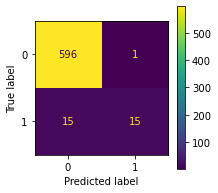

In [19]:
fig, ax = plot_conf_matrix(Y_test, Y_predict)
fig.savefig(fname=f'matrix.pdf', dpi=200, transparent=True, bbox_inches='tight', pad_inches=0)
